✅ Loaded data for packet sizes: [np.int64(2), np.int64(4), np.int64(6), np.int64(8)]
✅ Models: ['MLP', 'LSTM (seq=16)']
📊 PLOTTING INDIVIDUAL SLICE METRICS (eMBB & URLLC separately)


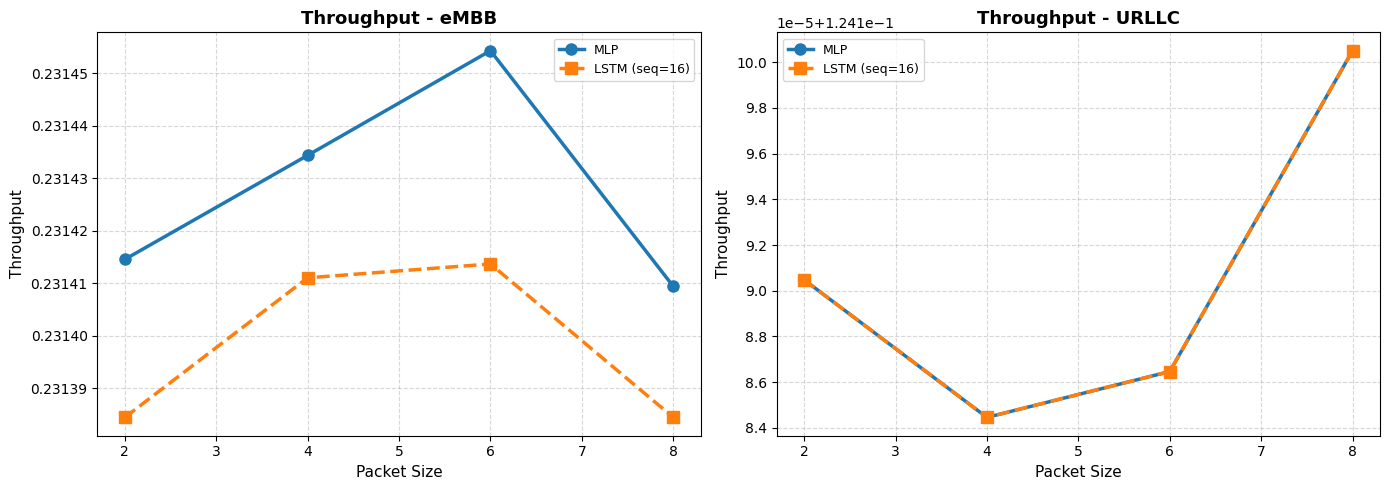

✅ Saved: slice_comparison_Throughput.pdf


/tmp/ipykernel_3040673/3821810630.py:128: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[slice_idx].set_yscale("log")


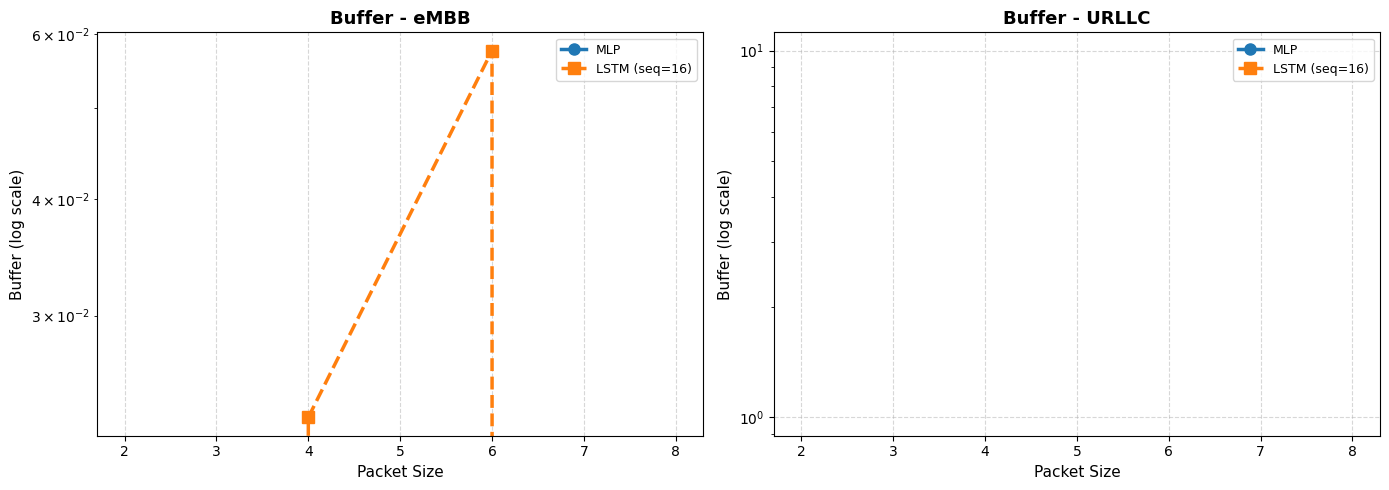

✅ Saved: slice_comparison_Buffer.pdf


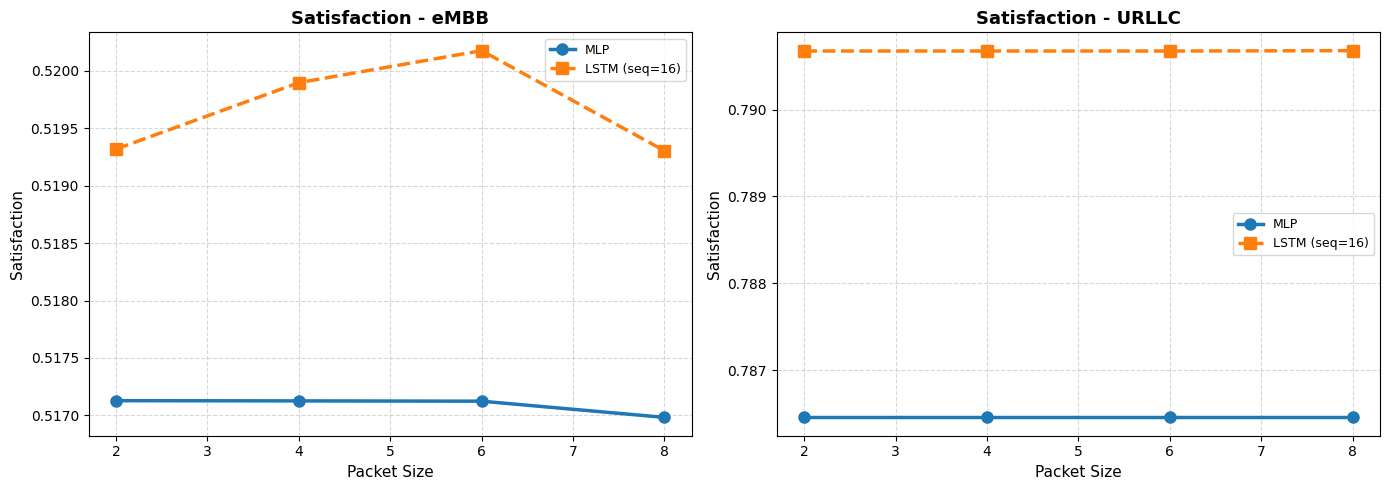

✅ Saved: slice_comparison_Satisfaction.pdf


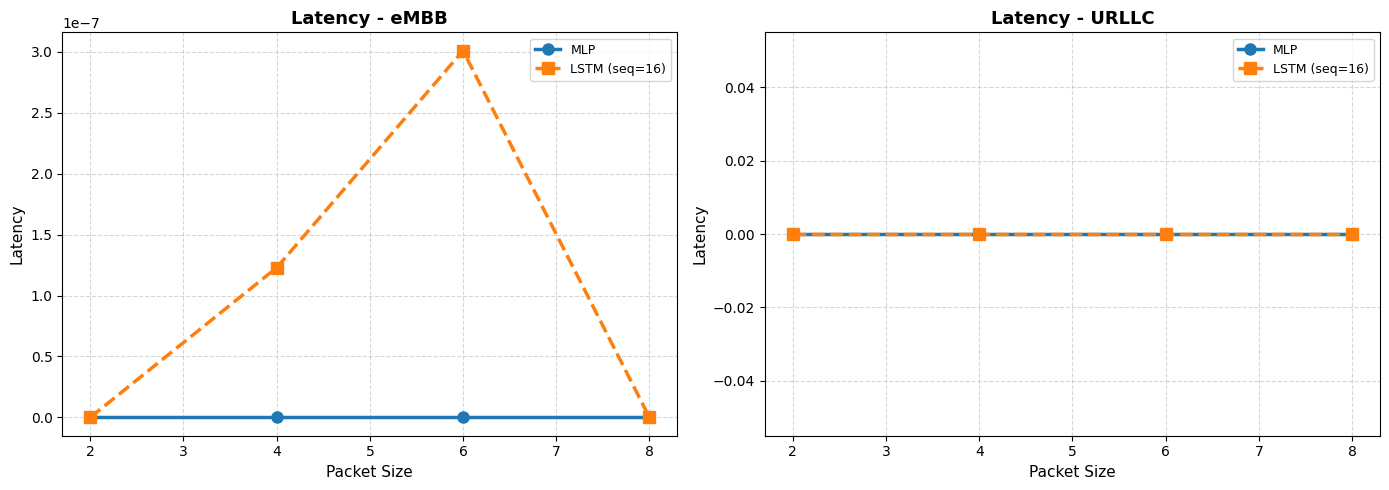

✅ Saved: slice_comparison_Latency.pdf


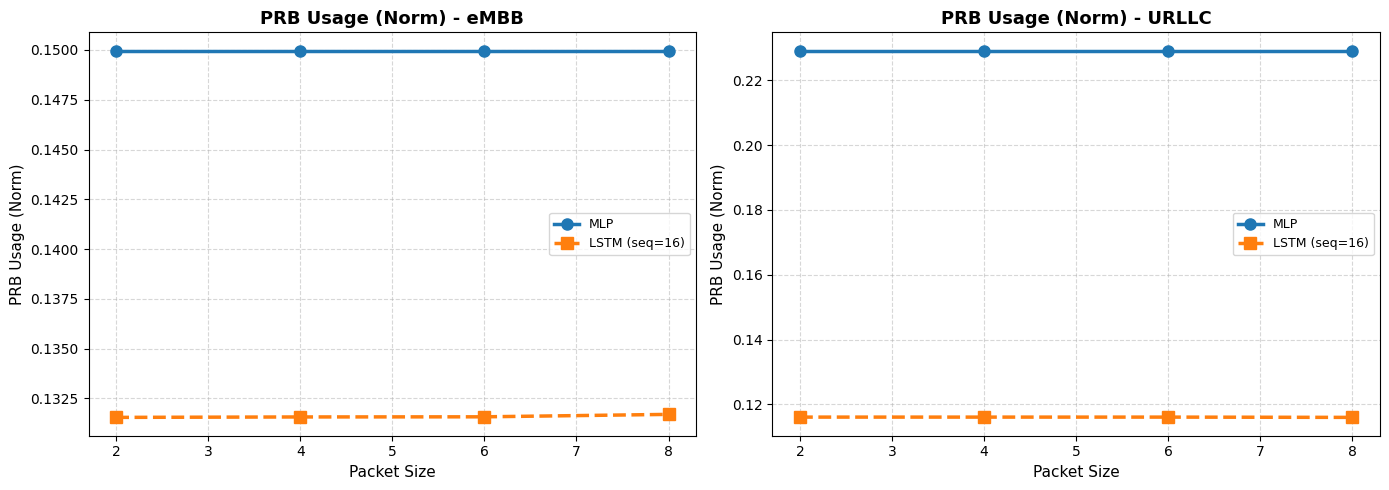

✅ Saved: slice_comparison_PRB_Usage_Norm.pdf


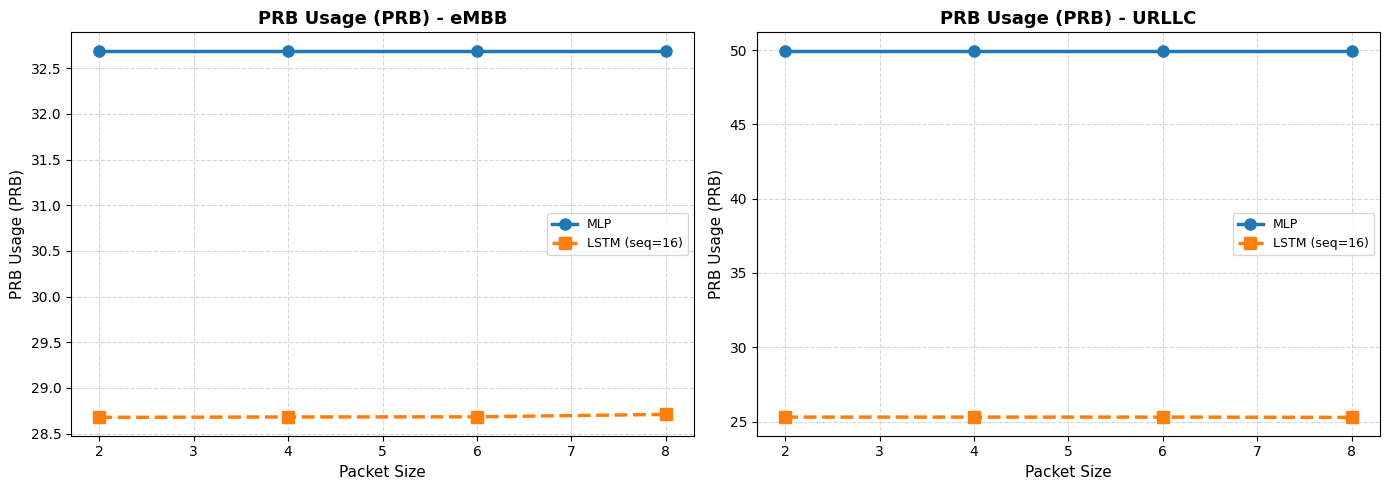

✅ Saved: slice_comparison_PRB_Usage_PRB.pdf

✅ Individual slice metric plots complete!

📊 PLOTTING AGGREGATED METRICS (average of eMBB & URLLC)


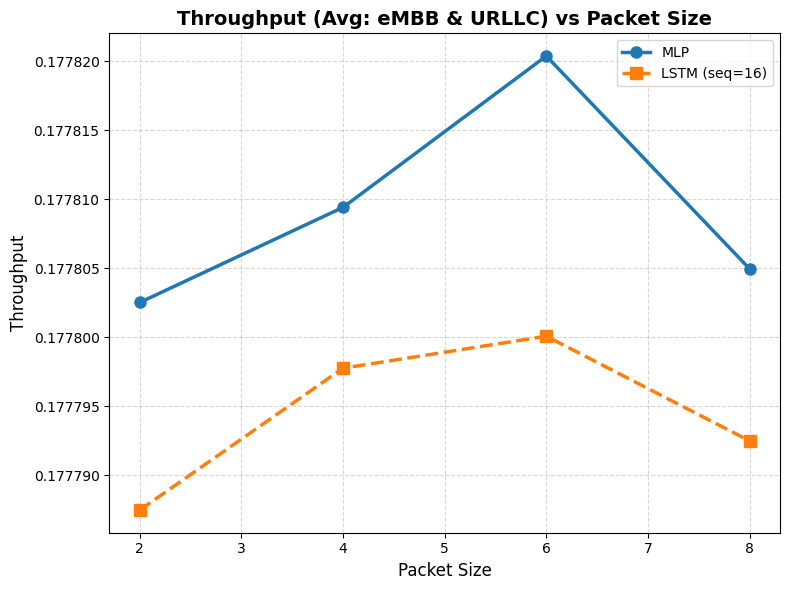

✅ Saved: aggregated_Throughput.pdf


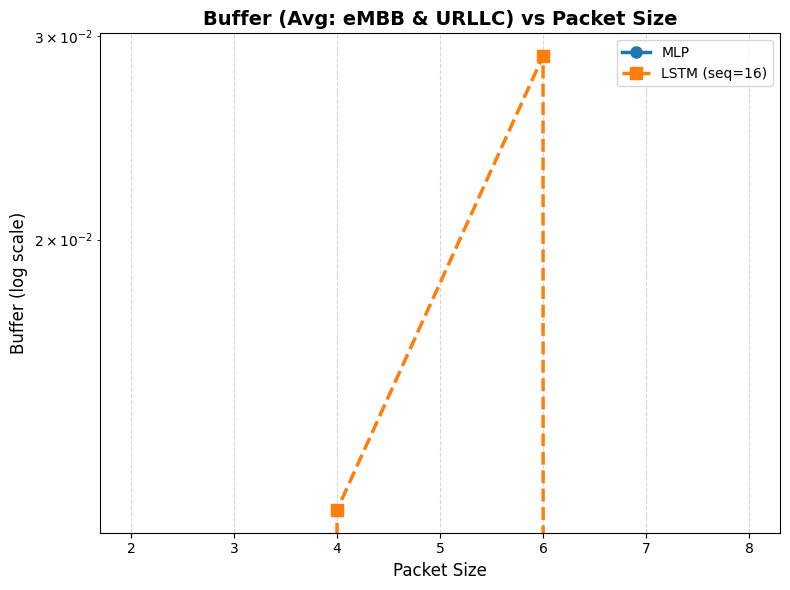

✅ Saved: aggregated_Buffer.pdf


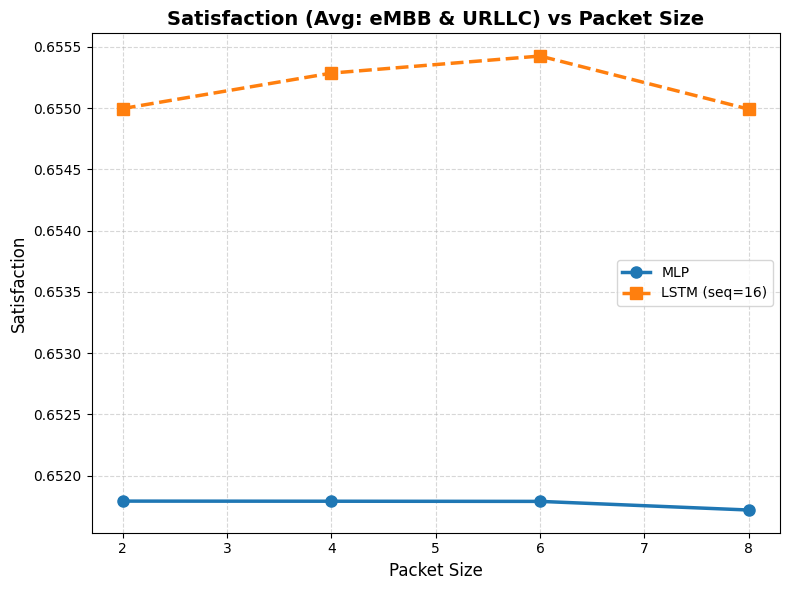

✅ Saved: aggregated_Satisfaction.pdf


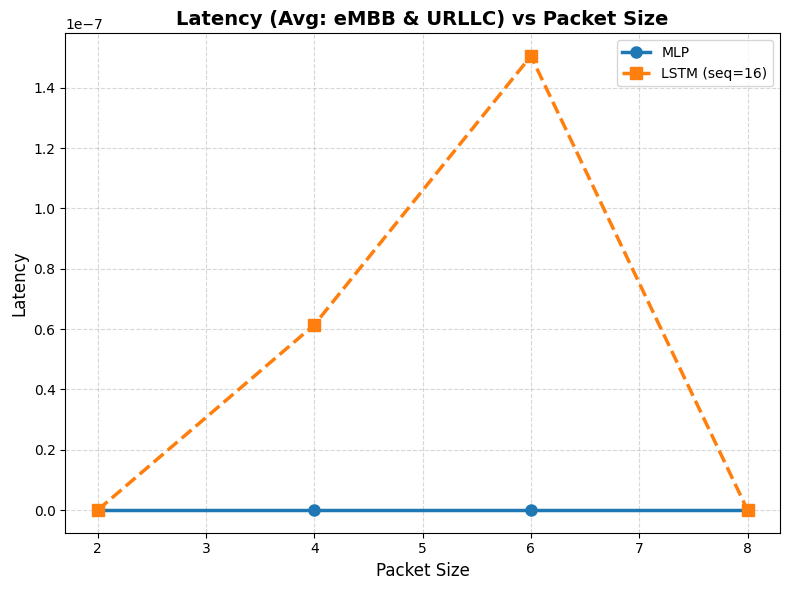

✅ Saved: aggregated_Latency.pdf


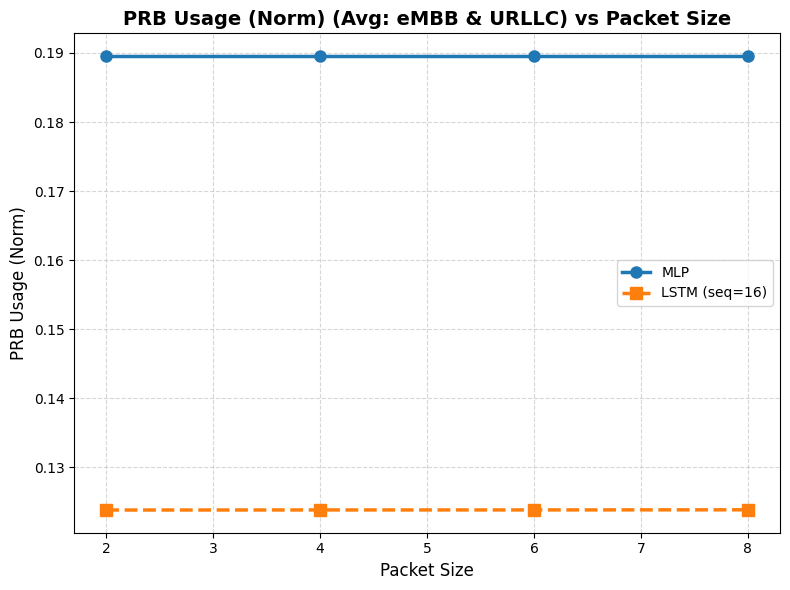

✅ Saved: aggregated_PRB_Usage_Norm.pdf


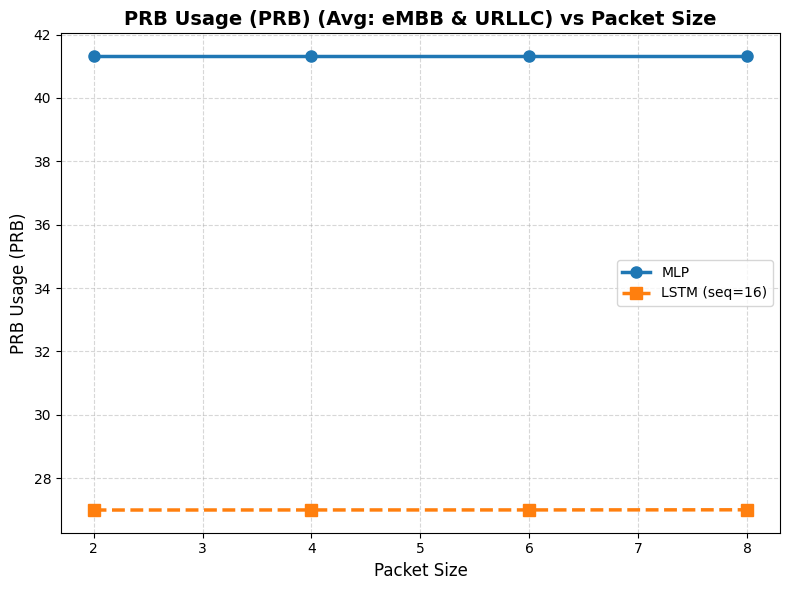

✅ Saved: aggregated_PRB_Usage_PRB.pdf

✅ All aggregated metric plots complete!


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ==================================================
# CONFIGURATION
# ==================================================
BASE_DIR = "./"

MODEL_DIRS = {
    "prb_gym_mlp": "MLP",
    #"prb_gym_lstm_seq4": "LSTM (seq=4)",
    "prb_gym_lstm_seq16": "LSTM (seq=16)",
}

CSV_NAME = "tensorboard_metrics_full_summary.csv"
SLICES = ["eMBB", "URLLC"]

# Define key metrics for plotting
KEY_METRICS = {
    "Throughput": "tx_mbps",
    "Buffer": "buffer_bytes",
    "Satisfaction": "satisfaction",
    "Latency": "latency",
    "PRB Usage (Norm)": "prb_usage_norm",
    "PRB Usage (PRB)": "prb_usage_prb",
}

# Plot styles
markers = ["o", "s", "D"]
linestyles = ["-", "--", "-."]

# ==================================================
# LOAD DATA
# ==================================================
def compute_all_from_slices(df_row, base):
    vals = []
    for sl in SLICES:
        col = f"{sl}_{base}"
        if col in df_row and pd.notna(df_row[col]):
            vals.append(df_row[col])
    return sum(vals) / len(vals) if vals else None


rows = []
packet_dirs = sorted(
    [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d)) and d.isdigit()],
    key=lambda x: int(x),
)

for pkt in packet_dirs:
    runs_dir = os.path.join(BASE_DIR, pkt, "runs")
    if not os.path.isdir(runs_dir):
        continue

    for model_folder in os.listdir(runs_dir):
        if model_folder not in MODEL_DIRS:
            continue

        csv_path = os.path.join(runs_dir, model_folder, CSV_NAME)
        if not os.path.exists(csv_path):
            print(f"⚠️ Missing: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"⚠️ Empty: {csv_path}")
            continue

        last = df.iloc[-1].to_dict()
        rec = {"Packet_Size": int(pkt), "Model": model_folder, "ModelLabel": MODEL_DIRS[model_folder]}

        for label, suffix in KEY_METRICS.items():
            for sl in SLICES:
                col = f"{sl}_{suffix}"
                if col in last:
                    rec[col] = last[col]
            rec[f"avg_{suffix}"] = compute_all_from_slices(last, suffix)
        rows.append(rec)

if not rows:
    raise SystemExit("❌ No data found. Check your BASE_DIR path and structure.")

all_data = pd.DataFrame(rows).sort_values(["Packet_Size", "ModelLabel"])
packet_sizes = sorted(all_data["Packet_Size"].unique())

print("✅ Loaded data for packet sizes:", packet_sizes)
print("✅ Models:", list(MODEL_DIRS.values()))

# ==================================================
# PLOT 1: Individual slice metrics vs Packet Size
# ==================================================
print("=" * 80)
print("📊 PLOTTING INDIVIDUAL SLICE METRICS (eMBB & URLLC separately)")
print("=" * 80)

for metric_label, metric_suffix in KEY_METRICS.items():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for slice_idx, slice_name in enumerate(SLICES):
        col = f"{slice_name}_{metric_suffix}"
        if col not in all_data.columns:
            print(f"⚠️ Skipping {metric_label} for {slice_name} (missing {col})")
            continue

        for i, (model_folder, model_label) in enumerate(MODEL_DIRS.items()):
            subset = all_data[all_data["Model"] == model_folder].sort_values("Packet_Size")
            if subset.empty:
                continue

            axes[slice_idx].plot(
                subset["Packet_Size"],
                subset[col],
                marker=markers[i % len(markers)],
                linestyle=linestyles[i % len(linestyles)],
                label=model_label,
                linewidth=2.5,
                markersize=8,
            )

        axes[slice_idx].set_title(f"{metric_label} - {slice_name}", fontsize=13, fontweight="bold")
        axes[slice_idx].set_xlabel("Packet Size", fontsize=11)
        axes[slice_idx].set_ylabel(metric_label, fontsize=11)
        axes[slice_idx].grid(True, linestyle="--", alpha=0.5)
        axes[slice_idx].legend(fontsize=9, loc='best')

        if "Buffer" in metric_label:
            axes[slice_idx].set_yscale("log")
            axes[slice_idx].set_ylabel(f"{metric_label} (log scale)", fontsize=11)

    plt.tight_layout()
    filename = f"slice_comparison_{metric_label.replace(' ', '_').replace('(', '').replace(')', '')}.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"✅ Saved: {filename}")

print("\n✅ Individual slice metric plots complete!")

# ==================================================
# PLOT 2: Aggregated metrics (average of eMBB & URLLC)
# ==================================================
print("\n" + "=" * 80)
print("📊 PLOTTING AGGREGATED METRICS (average of eMBB & URLLC)")
print("=" * 80)

for metric_label, metric_suffix in KEY_METRICS.items():
    agg_col = f"avg_{metric_suffix}"
    if agg_col not in all_data.columns:
        print(f"⚠️ Skipping aggregated {metric_label} (missing {agg_col})")
        continue

    plt.figure(figsize=(8, 6))

    for i, (model_folder, model_label) in enumerate(MODEL_DIRS.items()):
        subset = all_data[all_data["Model"] == model_folder].sort_values("Packet_Size")
        if subset.empty:
            continue

        plt.plot(
            subset["Packet_Size"],
            subset[agg_col],
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=model_label,
            linewidth=2.5,
            markersize=8,
        )

    plt.title(f"{metric_label} (Avg: eMBB & URLLC) vs Packet Size", fontsize=14, fontweight="bold")
    plt.xlabel("Packet Size", fontsize=12)
    plt.ylabel(metric_label, fontsize=12)

    if "Buffer" in metric_label:
        plt.yscale("log")
        plt.ylabel(f"{metric_label} (log scale)", fontsize=12)

    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    filename = f"aggregated_{metric_label.replace(' ', '_').replace('(', '').replace(')', '')}.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"✅ Saved: {filename}")

print("\n✅ All aggregated metric plots complete!")


✅ Loaded: 2/runs/prb_gym_mlp/tensorboard_metrics_full_summary.csv
✅ Loaded: 2/runs/prb_gym_lstm_seq4/tensorboard_metrics_full_summary.csv
✅ Loaded: 2/runs/prb_gym_lstm_seq16/tensorboard_metrics_full_summary.csv
✅ Loaded: 4/runs/prb_gym_mlp/tensorboard_metrics_full_summary.csv
✅ Loaded: 4/runs/prb_gym_lstm_seq4/tensorboard_metrics_full_summary.csv
✅ Loaded: 4/runs/prb_gym_lstm_seq16/tensorboard_metrics_full_summary.csv
✅ Loaded: 6/runs/prb_gym_mlp/tensorboard_metrics_full_summary.csv
✅ Loaded: 6/runs/prb_gym_lstm_seq4/tensorboard_metrics_full_summary.csv
✅ Loaded: 6/runs/prb_gym_lstm_seq16/tensorboard_metrics_full_summary.csv
✅ Loaded: 8/runs/prb_gym_mlp/tensorboard_metrics_full_summary.csv
✅ Loaded: 8/runs/prb_gym_lstm_seq4/tensorboard_metrics_full_summary.csv
✅ Loaded: 8/runs/prb_gym_lstm_seq16/tensorboard_metrics_full_summary.csv

✅ Loaded 12 data points
Available columns: ['run_name', 'reward', 'reward_running_avg', 'epsilon', 'episode_return', 'return_cumulative', 'eMBB_buffer_byte

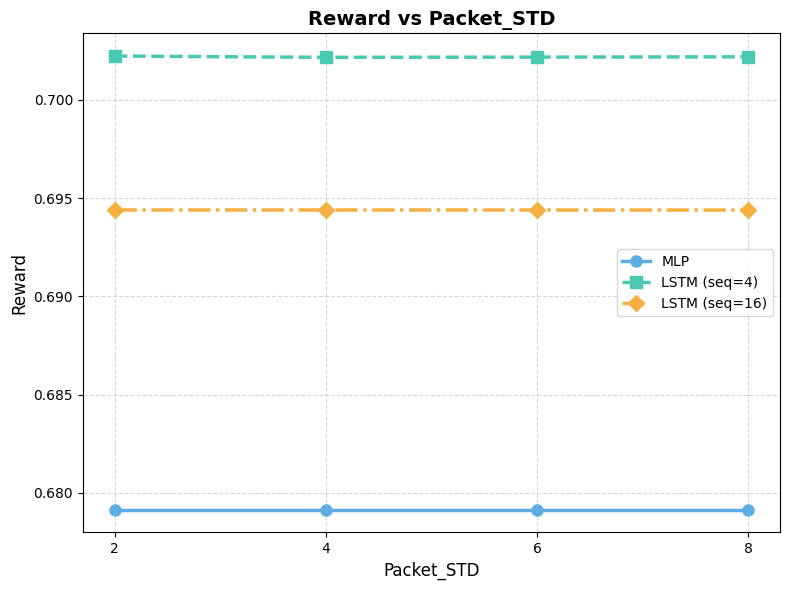

✅ Saved: Reward_Running_Avg_vs_Packet_STD.pdf


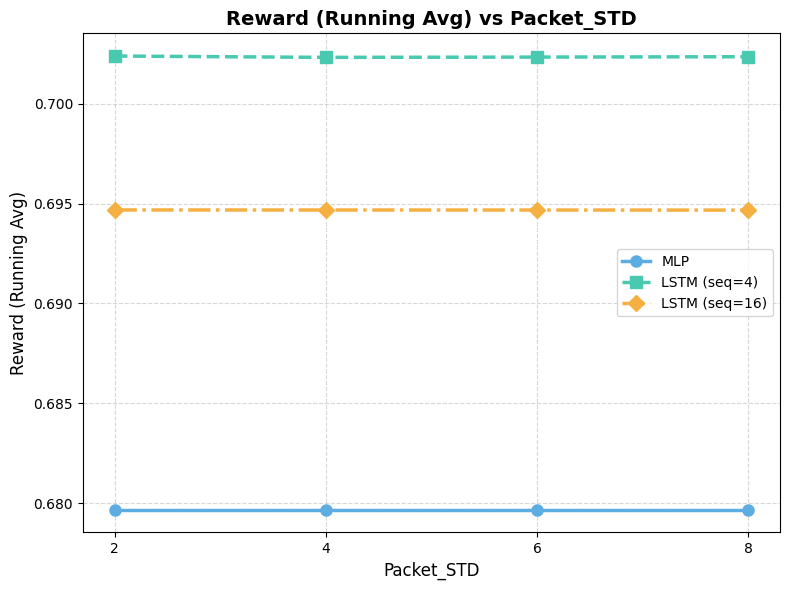

✅ Saved: Epsilon_vs_Packet_STD.pdf


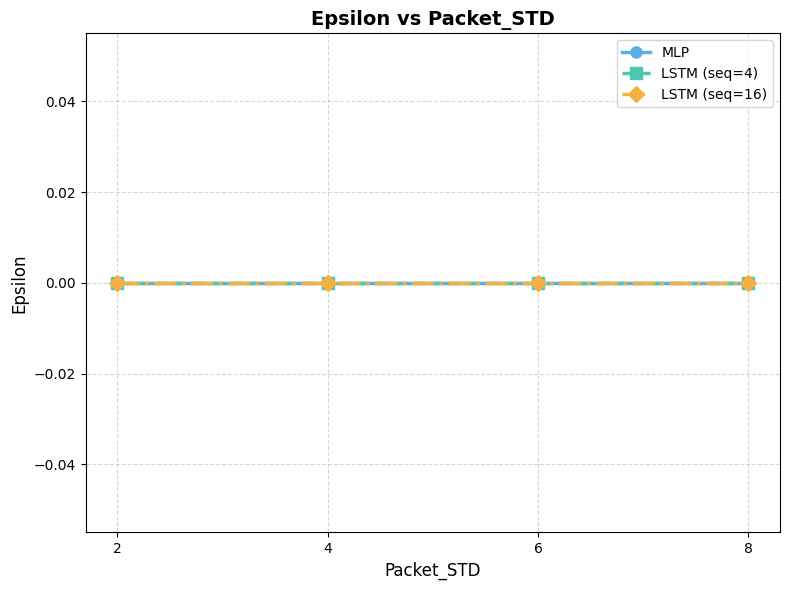

✅ Saved: Episode_Return_vs_Packet_STD.pdf


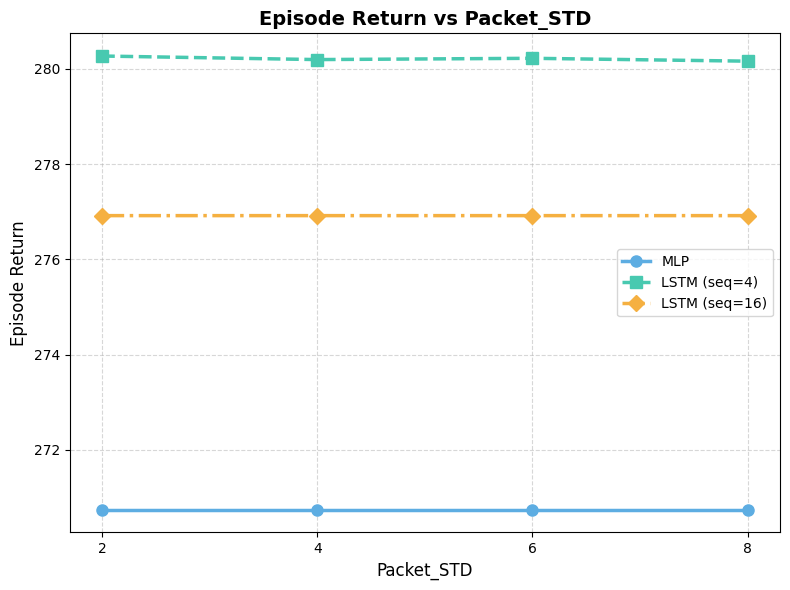


✅ Global metrics plotting complete!


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# ==================================================
# Configuration
# ==================================================
packet_std = [2, 4, 6, 8]
models = ["prb_gym_mlp", "prb_gym_lstm_seq4", "prb_gym_lstm_seq16"]
model_labels = {
    "prb_gym_mlp": "MLP",
    "prb_gym_lstm_seq4": "LSTM (seq=4)",
    "prb_gym_lstm_seq16": "LSTM (seq=16)",
}
model_colors = {
    "prb_gym_mlp": "#5DADE2",
    "prb_gym_lstm_seq4": "#48C9B0",
    "prb_gym_lstm_seq16": "#F5B041",
}

# ==================================================
# Metrics to plot (based on actual CSV columns)
# ==================================================
# Global metrics aggregated across slices
global_metrics = [
    ("reward", "Reward"),
    ("reward_running_avg", "Reward (Running Avg)"),
    ("epsilon", "Epsilon"),
    ("episode_return", "Episode Return"),
]

# Per-slice metrics (averaged across eMBB and URLLC)
slices = ["eMBB", "URLLC"]
per_slice_metric_groups = {
    "Throughput (Mbps)": [f"{s}_tx_mbps" for s in slices],
    "Buffer (Bytes)": [f"{s}_buffer_bytes" for s in slices],
    "Satisfaction": [f"{s}_satisfaction" for s in slices],
    "Latency": [f"{s}_latency" for s in slices],
    "PRB Usage (Norm)": [f"{s}_prb_usage_norm" for s in slices],
    "PRB Usage (PRB)": [f"{s}_prb_usage_prb" for s in slices],
    "PRB Grant Ratio": [f"{s}_prb_grant_ratio" for s in slices],
    "PRB Penalty": [f"{s}_prb_penalty" for s in slices],
    "Score": [f"{s}_score" for s in slices],
}

# ==================================================
# Load data from all UE folders and models
# ==================================================
all_results = []

for packet in packet_std:
    for model in models:
        # Find the CSV file for this Packet_STD and model
        csv_path = f"{packet}/runs/{model}/tensorboard_metrics_full_summary.csv"
        matching_files = glob.glob(csv_path)
        
        if not matching_files:
            print(f"⚠️  Missing file for Packet_STD={packet}, Model={model}")
            continue
        
        # Use the first matching file (most recent)
        csv_file = matching_files[0]
        
        try:
            df = pd.read_csv(csv_file)
            df["Packet_STD"] = packet
            df["Model"] = model
            
            # Take the last row if multiple entries exist
            all_results.append(df.iloc[-1])
            print(f"✅ Loaded: {csv_file}")
        except Exception as e:
            print(f"❌ Error loading {csv_file}: {e}")
            continue

# Combine into single DataFrame
if all_results:
    all_data = pd.DataFrame(all_results)
    print(f"\n✅ Loaded {len(all_data)} data points")
    print(f"Available columns: {list(all_data.columns)}\n")
else:
    print("❌ No data loaded!")
    all_data = pd.DataFrame()

# ==================================================
# Plot 1: Global metrics vs. number of UEs
# ==================================================
print("=" * 80)
print("📊 PLOTTING GLOBAL METRICS")
print("=" * 80)

markers = ["o", "s", "D"]
linestyles = ["-", "--", "-."]

for col, label in global_metrics:
    if col not in all_data.columns:
        print(f"⚠️  Skipping {label} - column '{col}' not found in CSV")
        continue
    
    plt.figure(figsize=(8, 6))
    
    for i, model in enumerate(models):
        subset = all_data[all_data["Model"] == model]
        if subset.empty:
            print(f"⚠️  No data for model: {model}")
            continue

        # Sort by Packet_STD for proper plotting
        subset = subset.sort_values("Packet_STD")
        
        plt.plot(
            subset["Packet_STD"],
            subset[col],
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=model_labels[model],
            color=model_colors[model],
            linewidth=2.5,
            markersize=8,
        )

    plt.title(f"{label} vs Packet_STD", fontsize=14, fontweight="bold")
    plt.xlabel("Packet_STD", fontsize=12)
    plt.ylabel(label, fontsize=12)
    
    # Log scale for certain metrics
    if any(keyword in label for keyword in ["Buffer", "Bytes"]):
        plt.yscale("log")
        plt.ylabel(f"{label} (log scale)", fontsize=12)
    
    plt.xticks(packet_std)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    
    # ✅ Save as PDF
    filename = f"{label.replace(' ', '_').replace('(', '').replace(')', '')}_vs_Packet_STD.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"✅ Saved: {filename}")
    
    plt.show()

print("\n✅ Global metrics plotting complete!")


📊 PLOTTING INDIVIDUAL SLICE METRICS (eMBB & URLLC separately)
✅ Saved: slice_comparison_Throughput.pdf


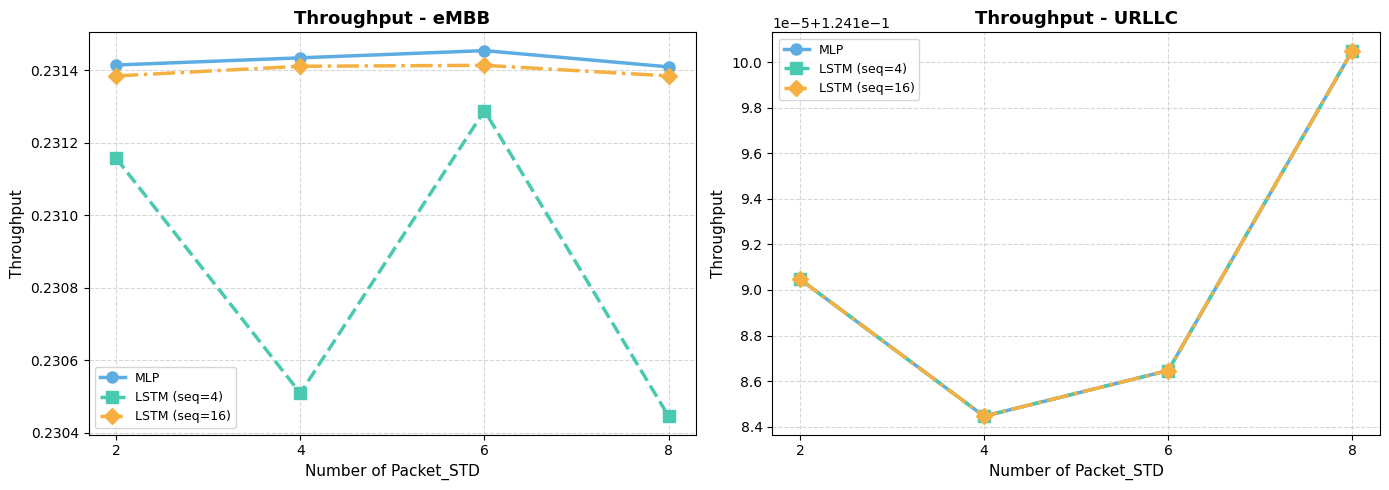

/tmp/ipykernel_3040673/1590042797.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[slice_idx].set_yscale("log")


✅ Saved: slice_comparison_Buffer.pdf


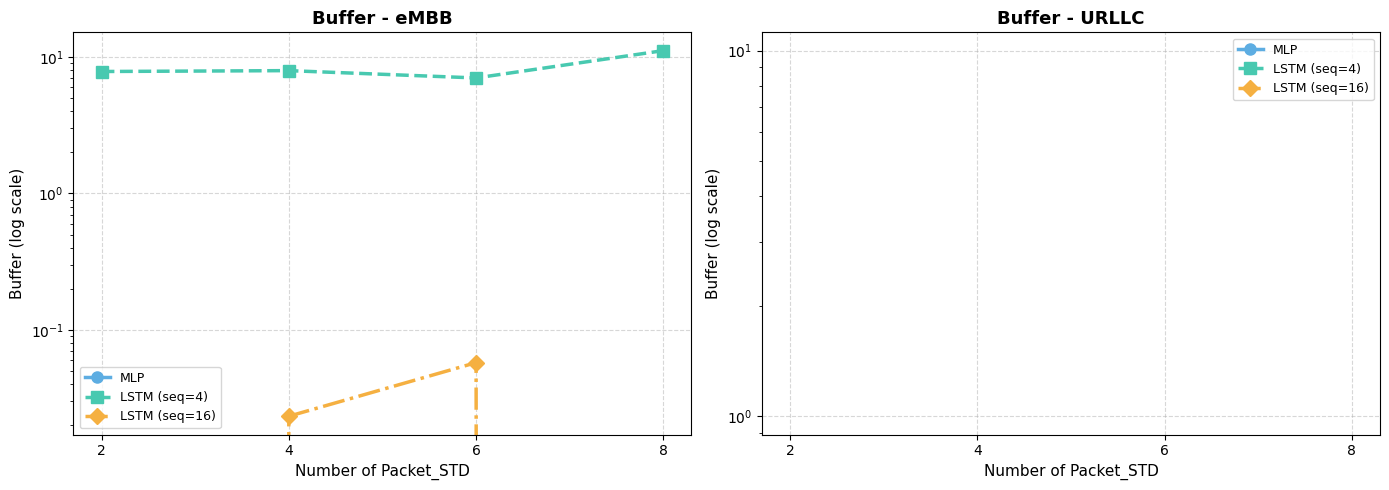

✅ Saved: slice_comparison_Satisfaction.pdf


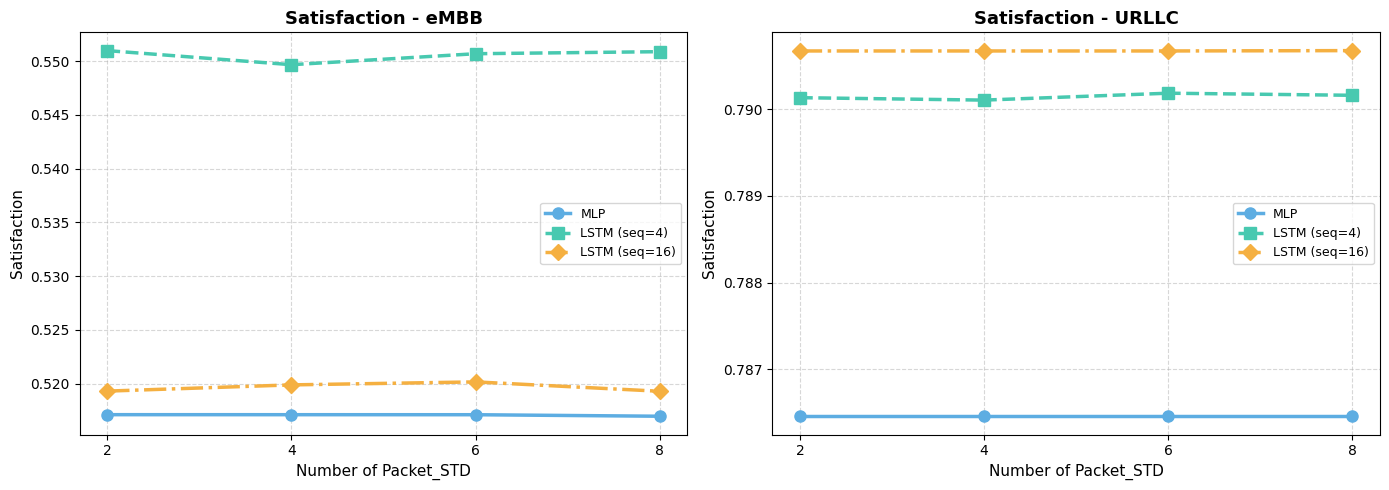

✅ Saved: slice_comparison_Latency.pdf


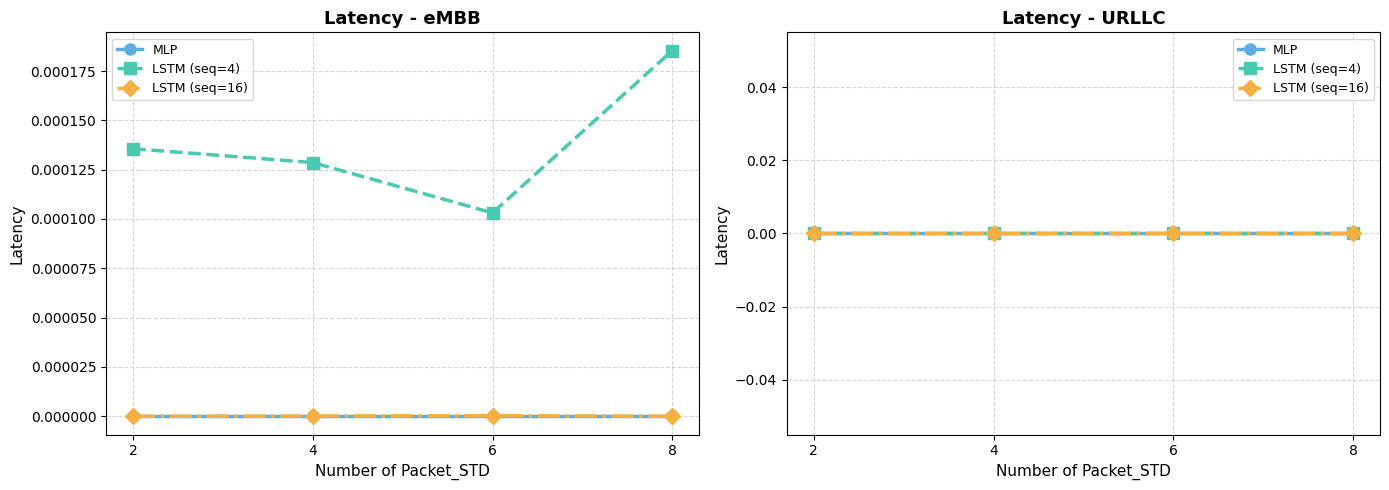

✅ Saved: slice_comparison_PRB_Usage_Norm.pdf


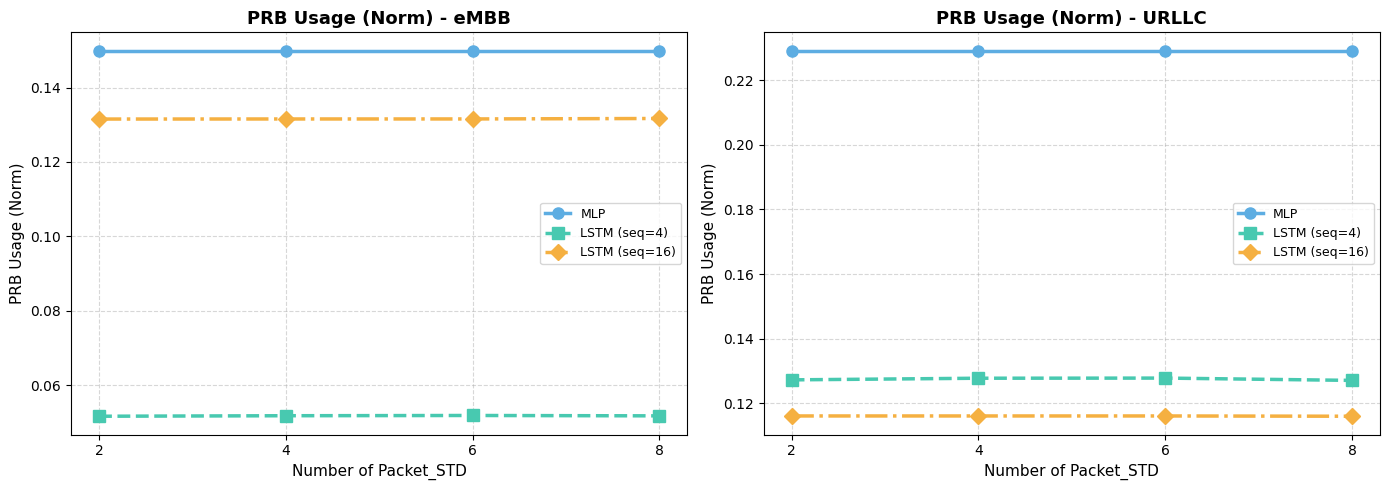

✅ Saved: slice_comparison_PRB_Usage_PRB.pdf


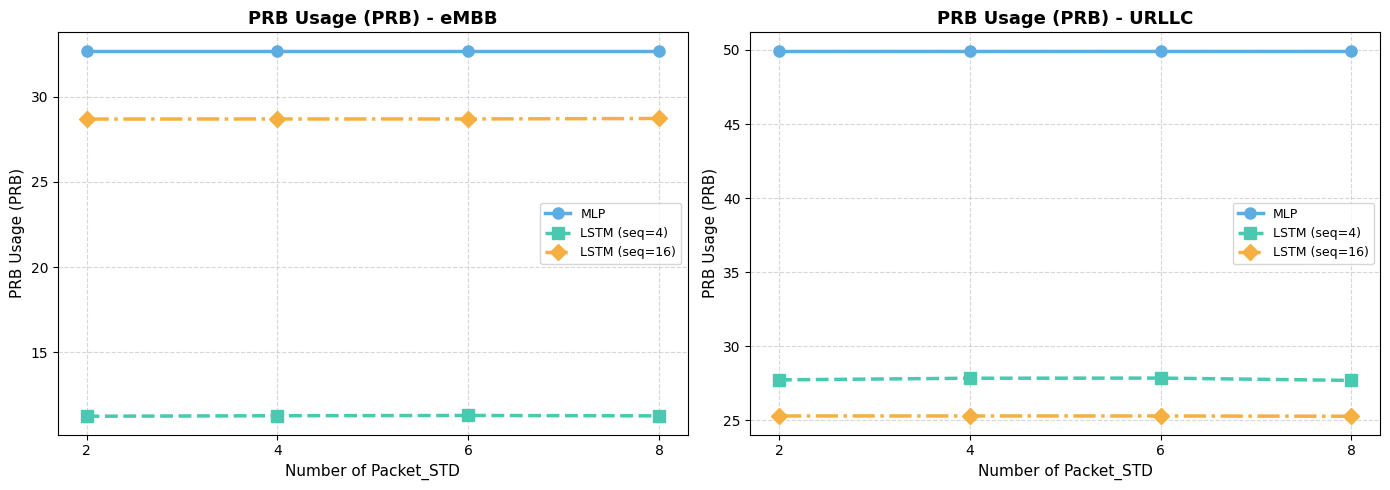


✅ Individual slice metrics plotting complete!

📊 PLOTTING AGGREGATED METRICS (average of eMBB & URLLC)
✅ Saved: aggregated_Throughput.pdf


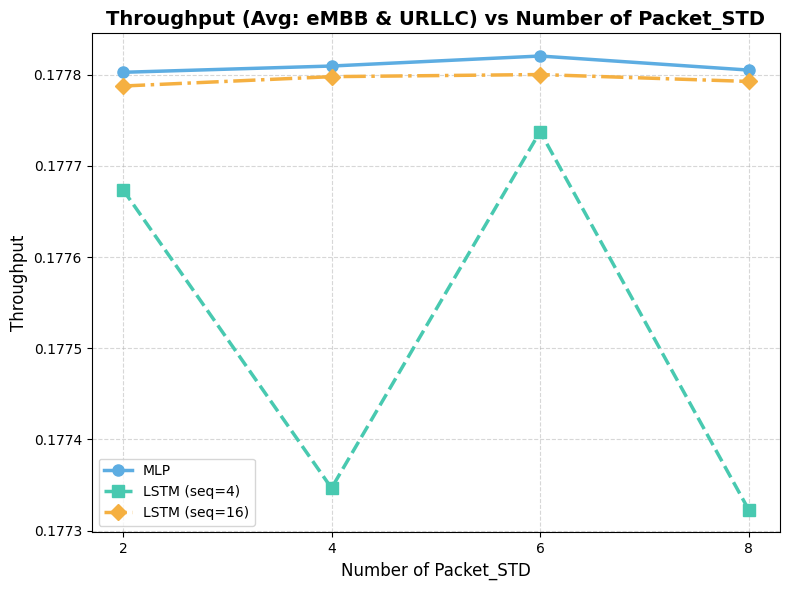

✅ Saved: aggregated_Buffer.pdf


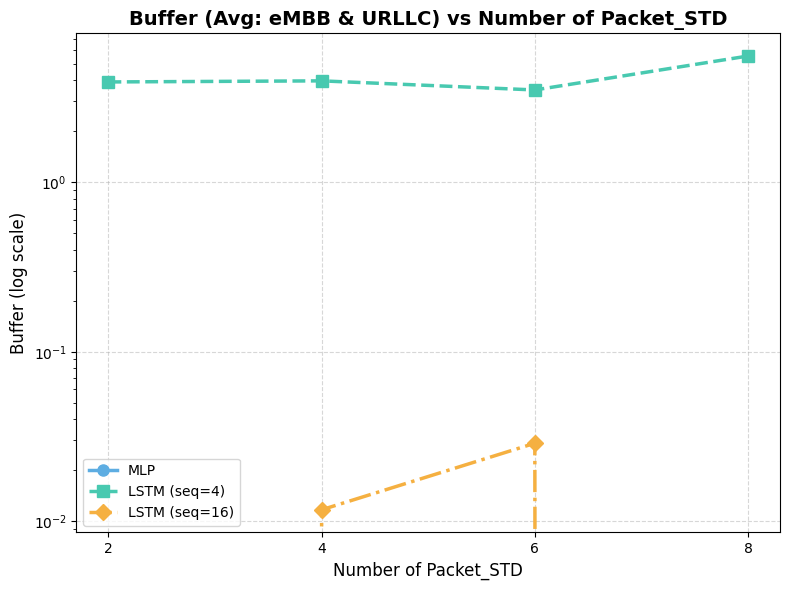

✅ Saved: aggregated_Satisfaction.pdf


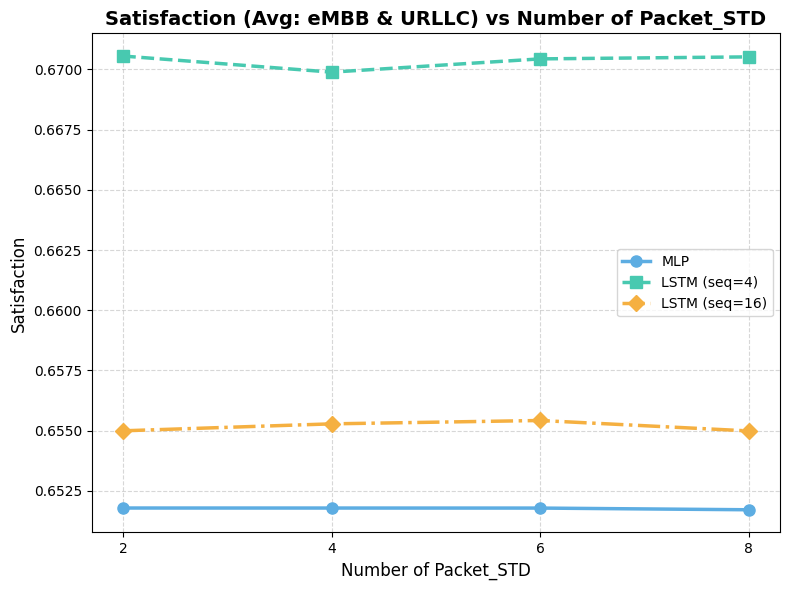

✅ Saved: aggregated_Latency.pdf


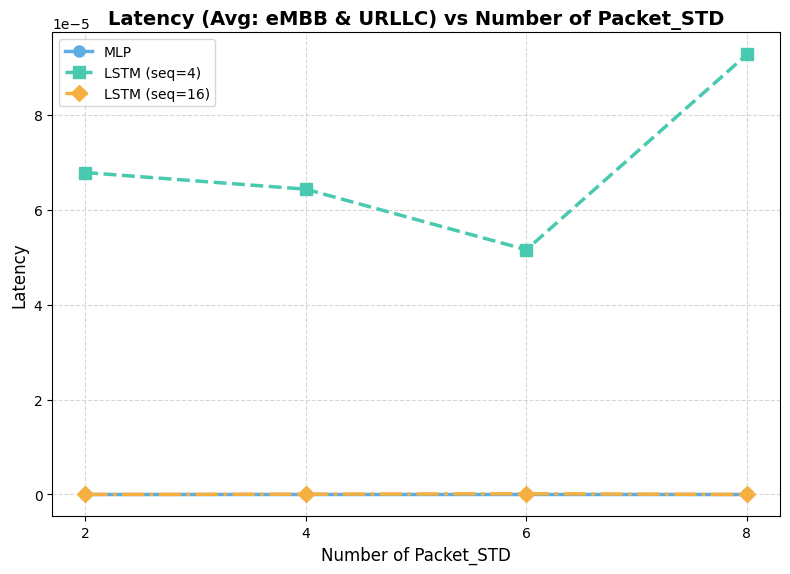

✅ Saved: aggregated_PRB_Usage_Norm.pdf


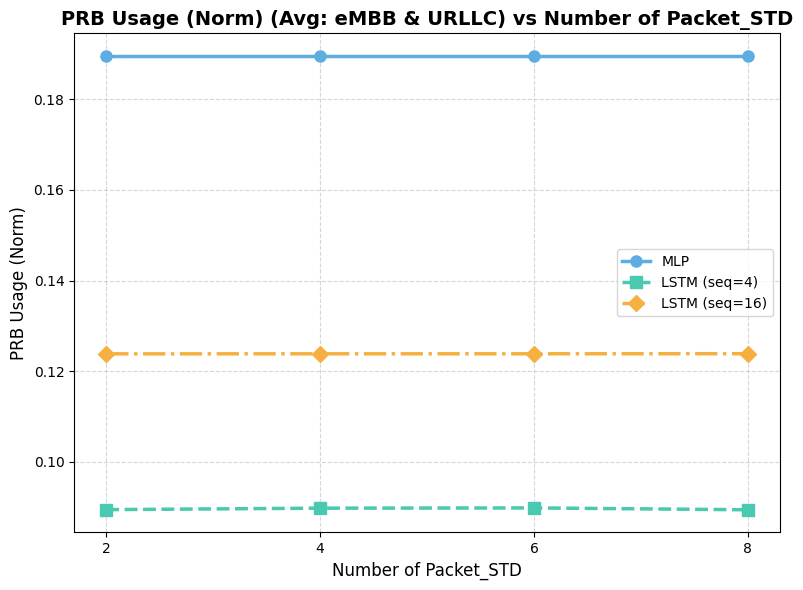

✅ Saved: aggregated_PRB_Usage_PRB.pdf


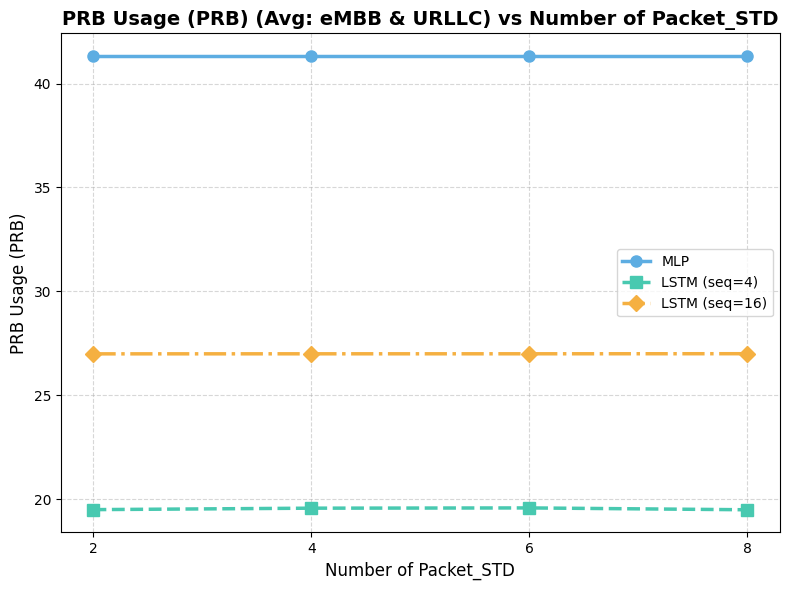


✅ All aggregated metrics plotting complete!


In [13]:
# ==================================================
# Plot 2: Individual per-slice metrics vs. number of UEs
# ==================================================
print("=" * 80)
print("📊 PLOTTING INDIVIDUAL SLICE METRICS (eMBB & URLLC separately)")
print("=" * 80)

markers = ["o", "s", "D"]
linestyles = ["-", "--", "-."]

# Define the key metrics you requested
key_metrics = {
    "Throughput": "tx_mbps",
    "Buffer": "buffer_bytes",
    "Satisfaction": "satisfaction",
    "Latency": "latency",
    "PRB Usage (Norm)": "prb_usage_norm",
    "PRB Usage (PRB)": "prb_usage_prb",
}

for metric_label, metric_suffix in key_metrics.items():
    # Plot for eMBB and URLLC separately
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for slice_idx, slice_name in enumerate(slices):
        col = f"{slice_name}_{metric_suffix}"
        
        if col not in all_data.columns:
            print(f"⚠️  Skipping {metric_label} for {slice_name} - column '{col}' not found")
            continue
        
        for i, model in enumerate(models):
            subset = all_data[all_data["Model"] == model]
            if subset.empty:
                continue

            subset = subset.sort_values("Packet_STD")

            axes[slice_idx].plot(
                subset["Packet_STD"],
                subset[col],
                marker=markers[i % len(markers)],
                linestyle=linestyles[i % len(linestyles)],
                label=model_labels[model],
                color=model_colors[model],
                linewidth=2.5,
                markersize=8,
            )
        
        axes[slice_idx].set_title(f"{metric_label} - {slice_name}", fontsize=13, fontweight="bold")
        axes[slice_idx].set_xlabel("Number of Packet_STD", fontsize=11)
        axes[slice_idx].set_ylabel(metric_label, fontsize=11)
        axes[slice_idx].set_xticks(packet_std)
        axes[slice_idx].grid(True, linestyle="--", alpha=0.5)
        axes[slice_idx].legend(fontsize=9, loc='best')
        
        # Log scale for buffer
        if "Buffer" in metric_label:
            axes[slice_idx].set_yscale("log")
            axes[slice_idx].set_ylabel(f"{metric_label} (log scale)", fontsize=11)
    
    plt.tight_layout()
    
    # ✅ Save as PDF
    filename = f"slice_comparison_{metric_label.replace(' ', '_').replace('(', '').replace(')', '')}.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"✅ Saved: {filename}")
    
    plt.show()

print("\n✅ Individual slice metrics plotting complete!")

# ==================================================
# Plot 3: Aggregated metrics (average of eMBB & URLLC)
# ==================================================
print("\n" + "=" * 80)
print("📊 PLOTTING AGGREGATED METRICS (average of eMBB & URLLC)")
print("=" * 80)

for metric_label, metric_suffix in key_metrics.items():
    # Create aggregated metric by averaging both slices
    agg_col = f"avg_{metric_suffix}"
    cols_to_avg = [f"{s}_{metric_suffix}" for s in slices if f"{s}_{metric_suffix}" in all_data.columns]
    
    if not cols_to_avg:
        print(f"⚠️  Skipping aggregated {metric_label} - no columns found")
        continue
    
    all_data[agg_col] = all_data[cols_to_avg].mean(axis=1)
    
    plt.figure(figsize=(8, 6))
    
    for i, model in enumerate(models):
        subset = all_data[all_data["Model"] == model]
        if subset.empty:
            continue
        
        subset = subset.sort_values("Packet_STD")
        
        plt.plot(
            subset["Packet_STD"],
            subset[agg_col],
            marker=markers[i % len(markers)],
            linestyle=linestyles[i % len(linestyles)],
            label=model_labels[model],
            color=model_colors[model],
            linewidth=2.5,
            markersize=8,
        )
    
    plt.title(f"{metric_label} (Avg: eMBB & URLLC) vs Number of Packet_STD", fontsize=14, fontweight="bold")
    plt.xlabel("Number of Packet_STD", fontsize=12)
    plt.ylabel(metric_label, fontsize=12)
    
    # Log scale for buffer
    if "Buffer" in metric_label:
        plt.yscale("log")
        plt.ylabel(f"{metric_label} (log scale)", fontsize=12)

    plt.xticks(packet_std)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    
    # ✅ Save as PDF
    filename = f"aggregated_{metric_label.replace(' ', '_').replace('(', '').replace(')', '')}.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"✅ Saved: {filename}")
    
    plt.show()

print("\n✅ All aggregated metrics plotting complete!")


In [ ]:
# ==================================================
# Plot 2: Per-slice metrics vs. number of UEs
# ==================================================
for metric_name, cols in slice_metric_groups.items():
    for slice_name, col in zip(slices, cols):
        plt.figure(figsize=(7, 5))
        for model in models:
            subset = all_data[all_data["Model"] == model]
            if subset.empty or col not in subset.columns:
                continue

            plt.plot(
                subset["UEs"],
                subset[col],
                marker="o",
                label=model_labels[model],
                color=model_colors[model],
                linewidth=2,
            )

            # Annotate values
            for _, row in subset.iterrows():
                val = row[col]
                text = f"{val:.3f}" if val < 1000 else f"{val:,.0f}"
                plt.text(row["UEs"], val * 1.02, text, ha='center', va='bottom', fontsize=8)

        plt.title(f"{metric_name} for {slice_name} vs Number of UEs", fontsize=14, fontweight="bold")
        plt.xlabel("Number of UEs", fontsize=12)
        plt.ylabel(metric_name, fontsize=12)
        if "Buffer" in metric_name:
            plt.yscale("log")
            plt.ylabel(f"{metric_name} (log scale)", fontsize=12)

        plt.xticks(ue_counts)
        plt.legend(fontsize=9)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()